In [88]:
from csoundengine.offline import OfflineEngine
e = OfflineEngine(outfile="~/tmp/pitchtrack.wav")

e.compile(r'''
instr pitchtrackvoice
    isndtable, ifreqtable, iminfreq, imaxfreq, ifftsize, ihopfactor, iwinsizefactor, ifftoversample, imindb, idbrange, inoisethresh passign 4
	ifreqtablesize = ftlen(ifreqtable)
    kfreq init 0.001
	kfreq0 init 0
	achannels[] = loscilx(1, 1, isndtable, 4, 1)
	a0 = achannels[0]
	iwinsize = ifftsize * iwinsizefactor
	ioverlap = int(iwinsize * ihopfactor)
	ifftsize2 = ifftsize * ifftoversample
    icutoff = imaxfreq * 7
	a0anal = butlp(butlp(a0, icutoff), icutoff)
	afol = follow2(a0, 0.01, 0.1)
	kgate = schmitt(dbamp(rms(afol)), imindb, imindb-idbrange*2) 
	fsig1 = pvsanal(a0anal, ifftsize, ioverlap, iwinsize, 0)
	fsigfeat = pvsanal(a0, ifftsize, ioverlap, iwinsize, 0)
	fsig2 = pvsanal(a0anal, ifftsize2, ioverlap, ifftsize2 * iwinsizefactor, 0)
	kfreq1, kamp1 pvspitch fsig1, ampdb(imindb) 
	kfreq2, kamp2 pvspitch fsig1, ampdb(imindb + idbrange*1.5)
	kfreq3, kamp3 pvspitch fsig2, ampdb(imindb + idbrange)
	kflatness = pow(pvsflatness:k(fsigfeat, 50), 1.5)
	kentropy0 = pvsentropy(fsigfeat, 50)
	kentropy = bpf:k(kentropy0, 0, 0, 0.55, 0, 6, .15, 20, .5, 60, .9, 180, 1.)
	; kpeakyness = pvsmagsumn(fsigfeat, 50, iminfreq) / max(0.000000001, pvsmagsum(fsigfeat))
	kpeakyness = pvsmagsumn(fsigfeat, -50, iminfreq)
    kunpeakyness = 1 - kpeakyness
	knoisyness = sqrt(kflatness*kflatness + kentropy*kentropy + kunpeakyness*kunpeakyness) / sqrt(3)
    knoisedb = dbamp(knoisyness)
	kt = eventtime()
	kcount = eventcycles()
	kvalid1 = kfreq1 > iminfreq && kfreq1 < imaxfreq ? 1 : 0
	kvalid2 = kfreq2 > iminfreq && kfreq2 < imaxfreq ? 1 : 0
	kvalid3 = kfreq3 > iminfreq && kfreq3 < imaxfreq ? 1 : 0
	
	ksource = 1
    ; First choose between freq1 and freq2
	if kvalid1 == 0 && kvalid2 == 0 then
		kfreq1 = 0
	elseif kvalid1 == 1 && kvalid2 == 1 && abs(kfreq1 - kfreq2)/(kfreq1+kfreq2) > 0.1 then
		kfreq1 = abs(kfreq1 - kfreq) < abs(kfreq2 - kfreq) ? kfreq1 : kfreq2
	elseif kvalid1 == 0 && kvalid2 == 1 then
		kfreq1 = kfreq2
	elseif kvalid1 == 1 && kvalid2 == 0 then
		kfreq1 = 0
		kvalid1 = 0
	endif

    ; now choose between the last value and freq3
	if kvalid1 == 0 && kvalid3 == 1 && kfreq0 > 0 then
        if abs(kfreq3 - kfreq) / kfreq < 0.1 then
			ksource = 2
        endif
	elseif kvalid1 == 1 && kvalid3 == 1 && abs(kfreq1 - kfreq3) / kfreq > 0.25 then
		ksource = abs(kfreq1 - kfreq) < abs(kfreq3 - kfreq) ? 1 : 2
	endif

    kfreq0prev = kfreq0
	kfreq0 = ksource == 1 ? kfreq1 : kfreq3
    
    if kfreq0 > iminfreq then
		kfreq0cont = mtof(lagud(ftom(kfreq0), 0.02, 0.04))
        kfreq = kfreq0prev == 0 ? kfreq0 : kfreq0cont
    endif
    knoisegate = schmitt(knoisedb, inoisethresh, inoisethresh - 6)
	kgate = kgate * (kfreq0 > 0 ? 1 : 0) * (1 - knoisegate)
	; kgate = max(trighold(kgate, 0.1), kgate)
	aenv = lagud:a(interp(kgate), 0.03, 0.03)
    aenv *= aenv
    asig = buzz(aenv, kfreq, 7, -1)
    outch 1, delay(a0, ifftsize / sr)
	outch 2, asig
    kidx = kcount*6 + 1
    tabw kfreq * kgate, kidx, ifreqtable
    tabw kt, kidx+1, ifreqtable
    tabw kgate, kidx+2, ifreqtable
    tabw kfreq1, kidx+3, ifreqtable
    tabw kfreq2, kidx+4, ifreqtable
    tabw kfreq3, kidx+5, ifreqtable
	tabw kcount, 0, ifreqtable
endin
''')


--Csound version 7.0 (double samples) Oct 28 2025
[commit: 15afda0ba81a895a4e87ac3ef5fe476702b072bf]
using libsndfile-1.2.2
sr = 44100.0, kr = 689.062, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
audio buffered in 256 sample-frame blocks
writing 1024-byte blks of shorts to /home/em/tmp/pitchtrack.wav (WAV)
SECTION 1:
error: get_arg_type2: Variable 'a0danal' used before defined
Line 15
error: Variable type for a0danal could not be determined, line 16
Parsing failed due to syntax errors
Stopping on parser failure


In [85]:
path = "/home/em/Lib/snd/samples/speech/voiceover-fragment.flac"
# path = "/home/em/Lib/snd/samples/speech/finneganswake-fragm01.flac"
# path = "./snd/colours-german-male.flac"
sndtab = e.readSoundfile(path)
sndtabinfo = e.tableInfo(sndtab)
duration = sndtabinfo.duration
numcycles = int(duration * e.sr / e.ksmps)
numcols = 6
freqtab = e.makeEmptyTable((numcycles + 100) * numcols)
e.sched('pitchtrackvoice', 0, duration + 0.1, sndtab, freqtab, 60, 300, 1024, 1/4, 1, 3, -40, 8, -6)
e.perform()

# Now retrieve information
outarr = e.tableData(freqtab)
datalen = int(outarr[0])
freqs = outarr[1:1+datalen*numcols:numcols]
times = outarr[2:1+datalen*numcols:numcols]
noises = outarr[3:1+datalen*numcols:numcols]
freqs1 = outarr[4:1+datalen*numcols:numcols]
freqs2 = outarr[5:1+datalen*numcols:numcols]
freqs3 = outarr[6:1+datalen*numcols:numcols]


freqs[freqs==0] = float("nan")
freqs2[freqs2>500] = float("nan")
freqs3[freqs3>500] = float("nan")

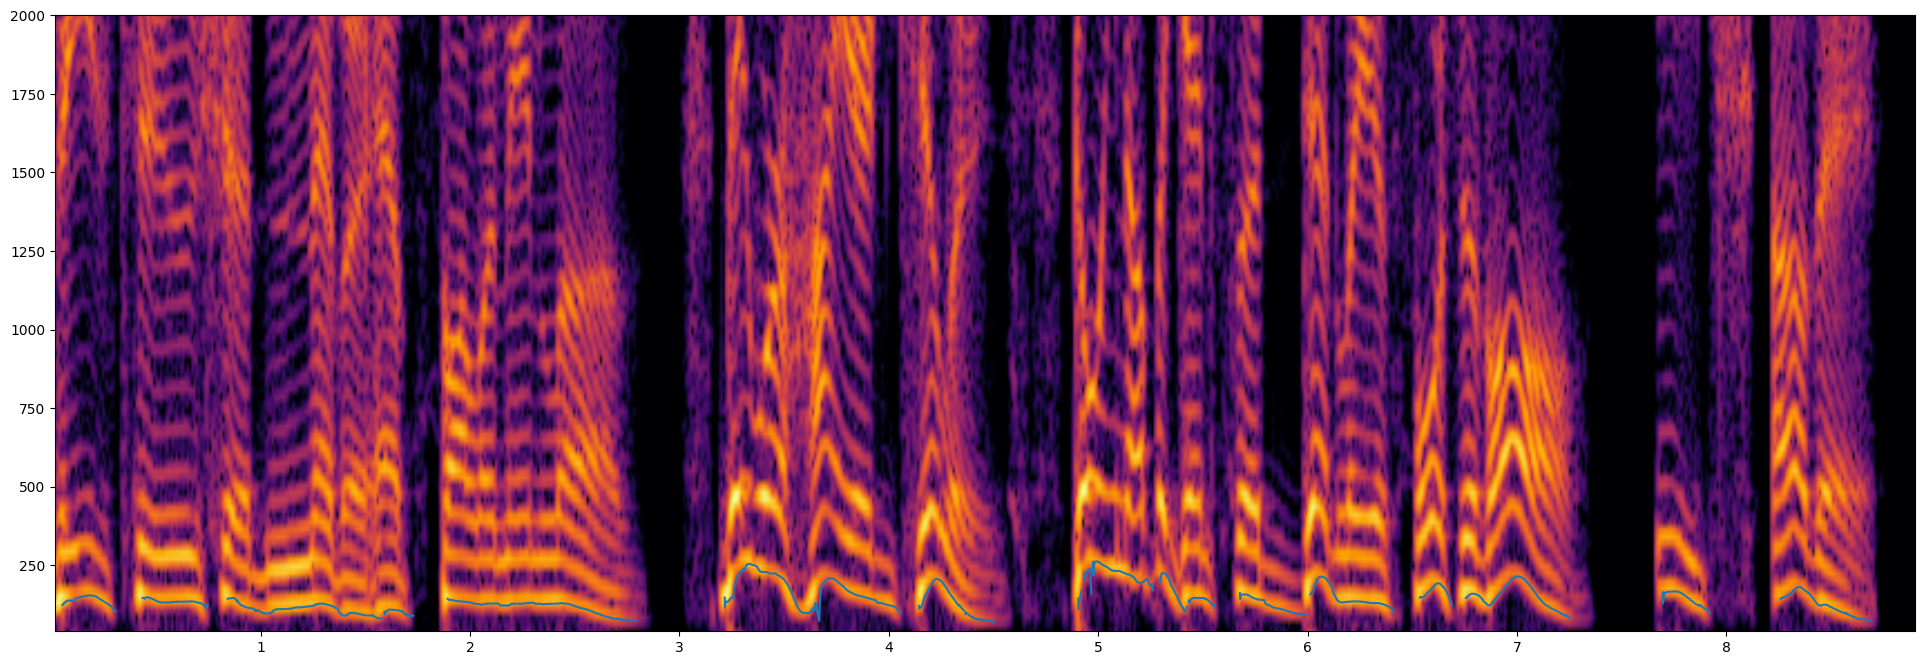

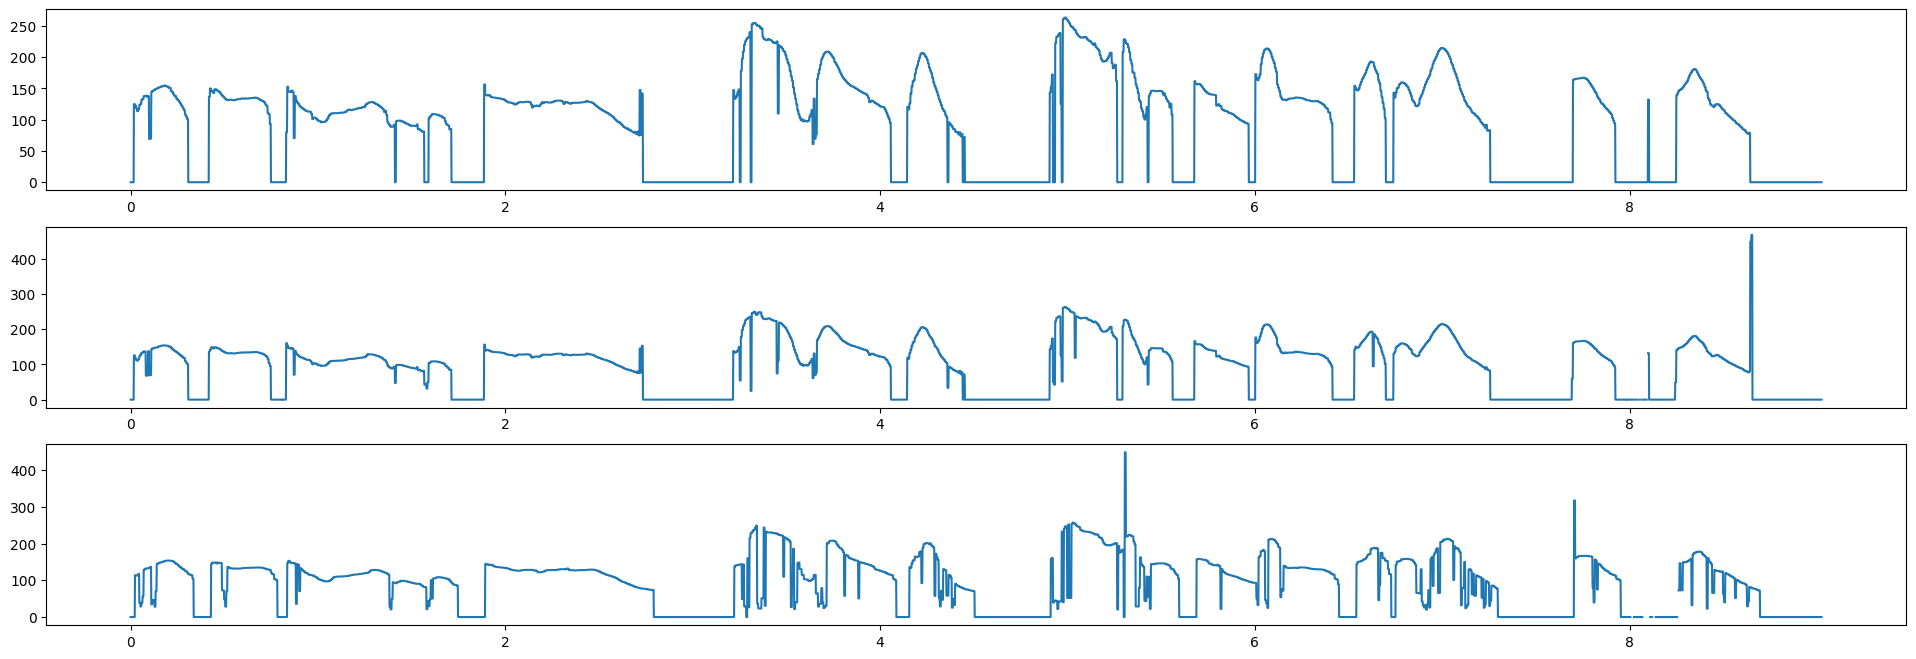

In [86]:
import matplotlib.pyplot as plt

samples = e.tableData(sndtab)
sr = e.tableInfo(sndtab)

import csoundengine.plotting
import sndfileio
samples, sr = sndfileio.sndread(path)
ax0 = csoundengine.plotting.plotSpectrogram(samples, sr, maxfreq=2000)
ax0.plot(times, freqs)

fig, axs = plt.subplots(3, 1, figsize=(24, 8))

axs[0].plot(times, freqs1)
axs[1].plot(times, freqs2)
axs[2].plot(times, freqs3)

resetting Csound instance
		   overall amps:  0.96874  1.00000
	   overall samples out of range:        0        0
0 errors in performance
512 1024 sample blks of shorts written to /home/em/tmp/pitchtrack.wav (WAV)


RenderJob(outfile='/home/em/tmp/pitchtrack.wav', samplerate=44100, encoding='float32', starttime=0.0, endtime=0.0, process=None)
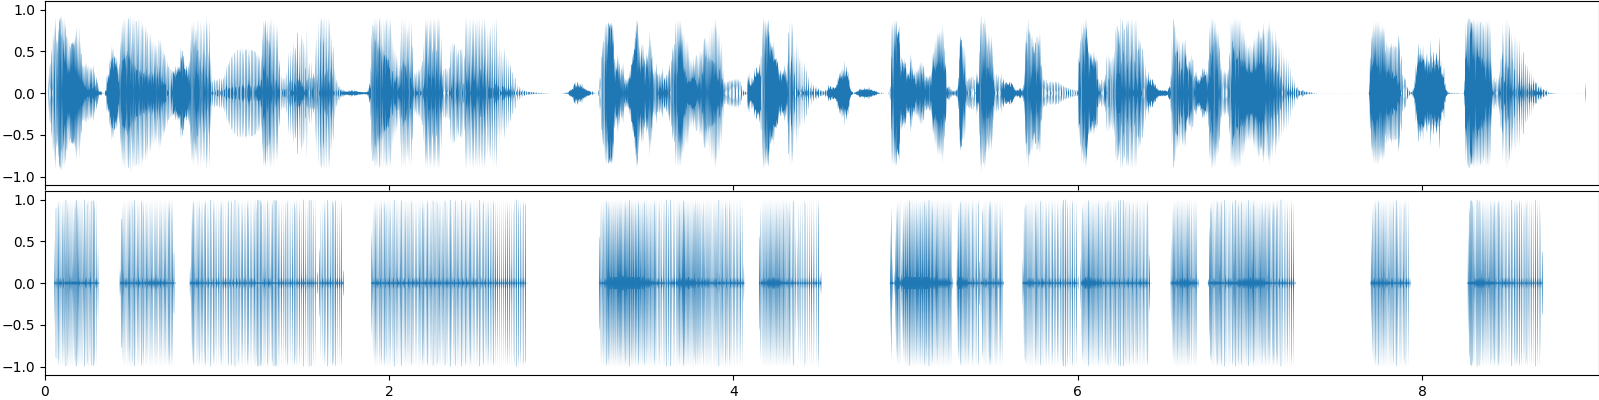

In [87]:
job = e.stop()
job